Relatório do trabalho
==============
**Nome:** Álvaro Leandro Cavalcante Carneiro
**Linguagem utilizada:** Python 3.6

Os códigos e o relatório foram desenvolvidos em um Jupyter notebook, sua versão online pode ser encontrada aqui: . Nessa versão é possível executar novamente os algoritmos.

# Qual o problema ? 
- Possuímos a seguinte equação matemática

![title](image/equacao.png)

- Qual o valor de **X**  que gera um maior resultado ?
- Não temos a resposta exata, ou seja, na teoria não sabemos o quanto essa função pode ser maximizada, portanto quanto maior o valor que conseguimos melhor.

## Representação 
- O domínio do problema se dá em um intervalo de [0, 1].
- **X** pode assumir qualquer valor dentro desse domínio.

## Objetivo
- **Maximizar** o resultado da equação através do maior valor possível de X.
- O melhor valor será definido por aquele que tiver o maior resultado final dentre todas as soluções encontradas

## Codificando
- Vamos começar com a importação das bibliotecas usadas, não só nesse problema mas em todos os outros também.

In [149]:
import math
import random
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

## Criação da função de custo / avaliação
- É o coração dos algoritmos de otimização. Todos eles tem essa função, que é responsável por indicar a aptidão ou desempenho que a solução candidata possui.
- Nossa otimização vai girar em torno dessas nossas funções de custo, pois sempre vamos fazer de tudo para maximizar ou minimizar o valor resultante dessas funções
- Nesse caso a função de custo é dada simplesmente pelo resultado da equação que deve ser **maximizado**

In [150]:
def funcao_custo(x):
    #caso o valor seja uma tupla Ex: (0.23) ele deve virar um int Ex: 0.23
    if isinstance(x, tuple):
        x = x[0]

    custo = 2 ** (-2 *((((x-0.1) / 0.9)) ** 2)) * ((math.sin(5*math.pi*x)) ** 6)
    return custo

## Exibindo os resultados
- Todos os algoritmos que serão executados vão ter os resultados exibidos por meio de um gráfico, que vai mostrar o melhor resultado ao longo das iterações e também por meio de um *print* no console com as informações numéricas de desempenho.
- A função de *plotar_busca* é a que gera nosso gráfico, onde o **eixo Y** é o custo/aptidão do algoritmo e o X é o número de iterações que foram executadas. 
- Pelo fato dos algoritmos serem estocásticos, eles foram executados várias vezes, portanto o objetivo desse gráfico é nos mostrar os melhores resultados obtidos em cada uma dessas execuções.
<hr>
- A função *exibir_sumario_resultados* por outro lado nos exibe na tela o resultado final do algoritmo baseado em todas as suas execuções.
- Lembrando que os resultados do algoritmo podem ser no sentido de maximização ou minimização de um valor, por isso um dos parâmetros dessa função é a escolha desse objetivo

In [151]:
def plotar_busca(resultados):
    t = np.arange(0.0, len(resultados), 1)
    
    plt.figure(figsize=(12,8))
    plt.plot(t, resultados)
    plt.show()

In [152]:
def exibir_sumario_resultados(solucao, custos, objetivo = max):
    print('Solução que gerou melhor resultado:', solucao[custos.index(objetivo(custos))])
    print('Melhor custo:', objetivo(custos))
    print('Média de custos:', np.mean(custos))
    print('Desvio padrão:', np.std(custos))
    plotar_busca(custos)

## Pegando os vizinhos
- A função *get_vizinhos* é usada para pegar os vizinhos no espaço de busca de cada dimensão da minha solução. Nesse problema temos uma única dimensão, que é o valor da variável X.
- Sendo assim, vamos pegar os vizinhos possíveis do nosso X, sendo o valor superior e inferior ao X atual, configurando os movimentos que ele poderá fazer pelo espaço de busca em cada iteração. 
- O "vizinho" nada mais é que uma **perturbação** na nossa solução atual, podendo ser uma constante ou usar, por exemplo, a fórmula gaussiana para determinar o valor da perturbação.
- Nesse caso, optei por usar uma constante para gerar a perturbação. A constante conseguiu explorar bem o espaço de busca, porém a sua grandeza foi escolhida baseada em testes de desempenho.
- Na nossa função de *get_vizinhos*, nós temos também um parâmetro não obrigatório de taxa de aprendizado, que pode ser usado para reduzir o valor da constante baseado nas iterações do algoritmo, fazendo com que os passos dados na nossa busca sejam menores conforme as iterações.
- Dessa forma, temos um passo maior a princípio, fazendo com que a exploração pelo espaço de busca comece de forma mais rápida, porém ele desacelera com o passar das iterações, diminuindo o risco de pularmos nosso máximo global por estar com um "passo" muito grande.
- Por fim nós também adicionamos operadores condicionais para garantir que nossos vizinhos sejam pontos dentro do nosso domínio.

In [153]:
def get_vizinhos(solucao, tx_aprendizado = 1):
    vizinhos = []
    constante = 0.005 / tx_aprendizado
    vizinho_superior = solucao + constante if solucao + constante < 1 else solucao
    vizinho_inferior = solucao - constante if solucao - constante > 0 else solucao
    
    vizinhos.append(vizinho_superior)
    vizinhos.append(vizinho_inferior)
    return vizinhos

### Pegando valor aleatório espaçado
- A função de *get_valor_aleatório* vai garantir que meus valores aleatórios iniciais tenham uma diferença mínima entre eles.
- Essa função é usada porque os algoritmos, principalmente o Hill Climbing, dependem de sua inicialização, pois iniciar em um ponto favorável gera resultados consideravelmente melhores do que em um ponto não favorável.
- Com isso, damos maior capacidade de exploração no espaço de busca para algoritmos que são mais fortes na explotação, através de multiplas inicializações.
- Esse espaço mínimo foi definido por uma constante, sua grandeza deve ser de acordo com o tamanho do domínio do problema.
- Nesse caso, nossa função recursiva tenta criar um novo ponto aleatório que tenha uma diferença de pelo menos 0.08 (valor escolhido baseado em testes) dos demais pontos existentes.

In [154]:
def get_valor_aleatorio(espaco, x=0):
    inicio = random.random()
    valor = []
    
    for i in espaco:
        diferenca = i - inicio
        if diferenca > 0.08 or diferenca < -0.08:
            valor.append(diferenca)

    if len(valor) == len(espaco) or x > 300:
        return inicio
    else:
        return get_valor_aleatorio(espaco, x = x + 1)

### Hill Climbing
- Meu primeiro algoritmo para resolver o problema foi o hill climbing, definido pela função *hill_climbing*
- Os critérios de parada são:
    - Atingir 400 iterações
    - Ficar 20 iterações sem melhoria
    - Ter apenas vizinhos piores que a solução atual
- O segundo critério é chamado de **parada no platô**.
- A ideia de parada no platô é valida caso nosso algoritmo fique preso em uma armadilha de "maximo local reto" como podemos ver na imagem, fazendo com que o algoritmo não tenha que ser executado pelo limite de 400 iterações.
- Claro que o parâmetro de platô também não pode ser muito pequeno, pois caso tenhamos caído em um "ombro (shoulder)" existe a esperança de melhoria.
    
![title](image/hill-climbing.png)

- Não foi usado uma semente aleatória para não remover a propriedade estocástica do algoritmo, principalmente pelo fato que foram realizadas diversas execuções.

In [155]:
def hill_climbing(funcao_custo, solucao_inicial, tx_aprendizado = 1):
    solucao = solucao_inicial
    custos = []
    count = 0
    parar_no_plato = 0

    while count <= 400:
        vizinhos = get_vizinhos(solucao, tx_aprendizado)
        
        atual = funcao_custo(solucao)
        melhor = atual 
        solucao_atual = solucao
        custos.append(atual)

        for i in range(len(vizinhos)):
            custo = funcao_custo(vizinhos[i])
            if custo >= melhor:
                parar_no_plato = parar_no_plato + 1 if custo == melhor else 0
                melhor = custo
                solucao = vizinhos[i]

        count += 1
        if melhor == atual and solucao_atual == solucao or parar_no_plato == 20:
            if parar_no_plato == 20: print('parada no platô')
            break

    return solucao, custos

## Execução e avaliação do Hill Climbing
- Possuímos aqui diversas formas de se inicializar e executar o algoritmo de subida da encosta para tentar buscar melhores resultados.
- Porém, não é interessante que a gente execute ele apenas uma vez, pois ele tem uma variação muito grande nos resultados, por depender muito da inicialização. Portanto, estou executando o algoritmo 30 vezes
- A função *executar_hill_climbing* possui parâmetros que vai modificar a forma como o hill climbing vai se comportar na busca por melhores soluções.
- Abaixo vamos discutir cada uma das execuções que o hill climbing foi submetido e os diferentes resultados.

In [156]:
def executar_hill_climbing(funcao_custo, iteracoes, espaco_minimo = False, 
                           get_melhor_resultado = False):
    custos = []
    solucao = []
    espaco_solucao = []
    
    for i in range(iteracoes):
        espaco_solucao.append(get_valor_aleatorio(espaco_solucao))
        
        valor_inicial = random.random() if espaco_minimo == False else espaco_solucao[
            len(espaco_solucao) - 1]   
        
        solucao_subida_encosta = hill_climbing(funcao_custo, valor_inicial) if get_melhor_resultado == False else hill_climbing(funcao_custo, solucao[
                custos.index(max(custos))] if len(custos) > 0 else random.random(), i + 1)
        
        solucao.append(solucao_subida_encosta[0])
        custos.append(max(solucao_subida_encosta[1]))
        custo_individual = solucao_subida_encosta[1]
        
    return solucao, custos, custo_individual

### Inicialização aleatória
- No primeiro teste, o algoritmo foi inicializado com um valor aleatório dentro do nosso domínio [0,1] pelas 30 iterações.

In [157]:
solucao, custos, grafico_subida_encosta = executar_hill_climbing(funcao_custo, 30)

Solução que gerou melhor resultado: 0.09996220912484666
Melhor custo: 0.9999989404104106
Média de custos: 0.6769865779584582
Desvio padrão: 0.2592609000843728


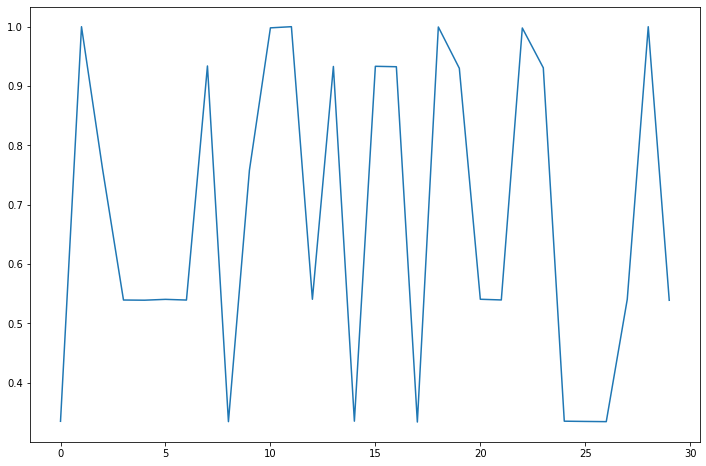

In [158]:
exibir_sumario_resultados(solucao, custos)

- Como podemos ver, conseguimos atingir o valor X de 0.1, chegando a um custo de 0.99.
- Porém fica claro no gráfico a enorme variáção dos resultados cada vez que o algoritmo é inicializado
- Isso se reflete obviamente nas médias e desvio padrão das 30 execuções, gerando um algoritmo bastante instável.

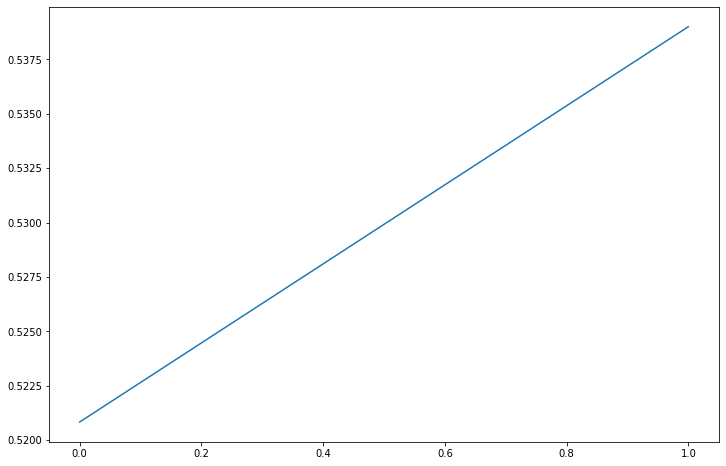

In [159]:
plotar_busca(grafico_subida_encosta)

- Todas as vezes que a função acima for executa teremos um gráfico um pouco diferente, mas a ideia do algoritmo de subida da encosta é sempre fazer esse movimento linear positivo, pois ele sempre tenta melhorar seus resultados, na pior das hipóteses teremos uma linha reta constante.

### Explorando o espaço de busca
- No segundo teste, usamos nossa função *get_valor_aleatório* para garantir um espaçamento entre os valores randômicos iniciais, aumentando a exploração do espaço de busca.

In [160]:
solucao, custos, grafico_subida_encosta = executar_hill_climbing(funcao_custo, 30, True)

Solução que gerou melhor resultado: 0.09987005633000012
Melhor custo: 0.9999874722861264
Média de custos: 0.7416088224309867
Desvio padrão: 0.22570725567602468


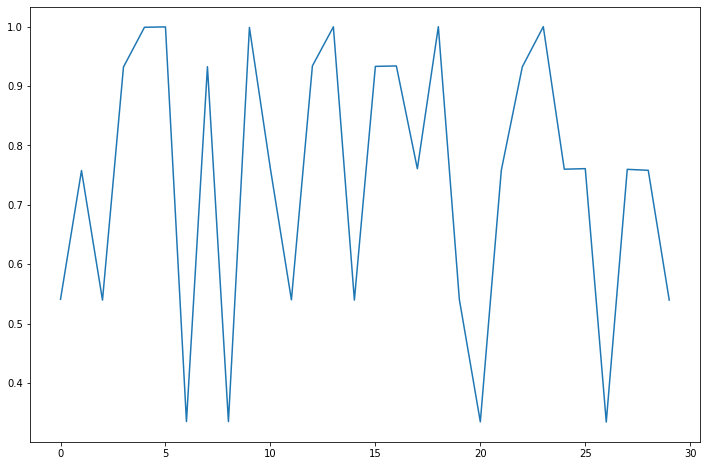

In [161]:
exibir_sumario_resultados(solucao, custos)

- É possível observar que os resultados não mudaram muito em relação à versão anterior, possivelmente se tivéssemos um espaço de busca maior do que [0,1] essa abordagem seria mais impactante para os resultados, todavia, não foi efetivo nesse contexto.

### Limitando o espaço de busca
- A ideia aqui é iniciar o algoritmo não de forma aleatória, mas baseado nos resultados obtidos anteriormente, fazendo com que nosso foco esteja nos melhores resultados.
- Claro que apenas iniciar com o melhor valor da execução anterior sem modificar a forma como obtemos os vizinhos não seria bom, pois a execução anterior foi interrompida justamente pela falta de melhoria.
- Portanto, utilizamos aqui a "taxa de aprendizado" discutiva anteriormente, fazendo com que o valor da nossa constante fique menor em cada iteração.

In [162]:
solucao, custos, grafico_subida_encosta = executar_hill_climbing(funcao_custo, 30, True, True)

Solução que gerou melhor resultado: 0.6986966189145914
Melhor custo: 0.5407952885869057
Média de custos: 0.5407400808321643
Desvio padrão: 0.00013795356156811288


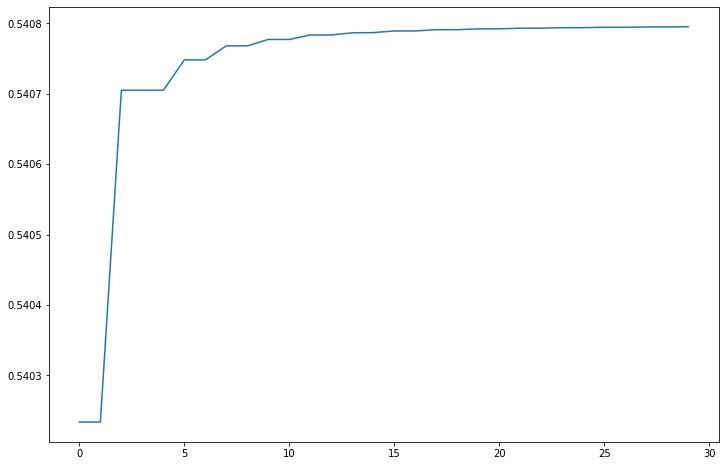

In [163]:
exibir_sumario_resultados(solucao, custos)

- Dessa forma, o algoritmo voltou a ser completamente dependente da sua inicialização, mesmo que executado diversas vezes, se o ponto inicial é desfavorável então ele todo se sai mal.
- Todavia essa abordagem é a que consegue chegar mais próxima do nosso máximo global, pois os passos dados são cada vez menores, gerando chances maiores de atingir o ponto global caso estejamos na "montanha" correta.
- Em um problema com mais dimensões essa abordagem pode ser ainda mais benéfica, pois leva em consideração o espaço de busca onde os valores estão se saindo bem, apesar de claro, poder se limitar bastante aos pontos locais.

# Simulated annealing
O segundo algoritmo utilizado para tentar resolver o problema foi o recozimento simulado.

- A diferença dele para o Hill Climbing é que ele tem uma probabilidade P de aceitar valores negativos
- Quanto mais no início do algoritmo, maior a sua chance de aceitar um valor negativo

### Probabilidade
- A probabilidade do simulated annealing é geralmente dada pela função exponencial exp(x)
- Nessa função, elevamos o número de euler ~2.7 à um valor de X.
- O X no nosso caso é o resultado da subtração entre o novo custo e o custo anterior divido pela temperatura: **(x' - x) / T**
- A temperatura vai diminuindo gradativamente, limitando nossas iterações e fazendo com que a probabilidade de se aceitar valores negativos também diminua

### Pros e contras dessa abordagem
- Esse algoritmo tem uma tendência a se sair melhor do que o subida da encosta pois permite uma maior exploração do espaço de busca ao aceitar valores negativos
- Todavia, ele possui parâmetros que devem ser otimizados para melhor funcionamento do algoritmo, sendo eles a temperatura e a taxa de resfriamento.
- Esses parâmetros vão afetar diretamente o número de iterações e também a probabilidade de aceitar valores negativos.
- A respeito da temperatura, encontrei alguns problemas para definir seu valor, pois valores pequenos resultavam em um número de iterações muito reduzido e valores grandes deixaram a resultado da função de probabilidade discutido anteriormente sempre próximo a 100%, fazendo com que o algoritmo aceite valores negativos em todas as iterações.
- Por conta disso, eu implementei uma função alternativa de probabilidade.

### Função alternativa de probabilidade
- Nessa função, começamos com 100% de probabilidade de aceitar valores negativos e conforme as iterações, vamos diminuindo esse valor.
- Essa redução de valor é definida por uma constante e essa constante é definida pelo número de iterações do nosso algoritmo.
- Um exemplo simples, se nosso algoritmo vai ter 10 iterações, nossa constante recebe um valor de 10 e a cada iteração nossa probabilidade vai ser subtraída por essa constante. 
1. *p = 100 - 10 = 90*
2. *p = 90 - 10 = 80*
- A vantagem de usar essa abordagem é que não precisamos nos preocupar em encontrar um valor de T que se adapte à grandeza do nosso domínio, fazendo com que nossa probabilidade seja genérica para qualquer problema.
- A desvantagem é que essa probabilidade não leva em consideração a diferença entre o valor atual e o novo valor como nossa função exponencial faz.

- A função *get_iteracoes* abaixo calcula quantas iterações nosso algoritmo terá, baseado na temperatura e taxa de resfriamento, para definir o valor da nossa constante de diminuição de probabilidade discutida anteriormente

In [164]:
def get_iteracoes(temperatura, resfriamento):
    count = 0
    while temperatura > 0.1:
        temperatura = temperatura * resfriamento
        count += 1
    return count

In [165]:
def simulated_annealing(funcao_custo, temperatura = 100.0, resfriamento = 0.95, passo = 1):
    iteracoes = get_iteracoes(temperatura, resfriamento)
    probabilidade = 100
    queda_prob = probabilidade / iteracoes
    solucao = random.random()
    custos = []
    parar_no_plato = 0

    while temperatura > 0.1:
        vizinhos = get_vizinhos(solucao)
        
        atual = funcao_custo(solucao)
        melhor = atual 
        solucao_atual = solucao
        custos.append(atual)

        for i in range(len(vizinhos)):
            
            if parar_no_plato == 20:
                break

            custo = funcao_custo(vizinhos[i])
            probabilidade = probabilidade - queda_prob 
            
            if custo >= melhor or random.random() < probabilidade:
                parar_no_plato = parar_no_plato + 1 if solucao_atual == solucao else 0
                melhor = custo
                solucao = vizinhos[i]
               
        temperatura = temperatura * resfriamento

    return solucao, custos

In [166]:
custos = []
solucao = []

for i in range(30):
    solucao_tempera_simulada = simulated_annealing(funcao_custo)
    solucao.append(solucao_tempera_simulada[0])
    custos.append(max(solucao_tempera_simulada[1]))
    custo_individual = solucao_tempera_simulada[1]

Solução que gerou melhor resultado: 0.10018779046957216
Melhor custo: 0.9999738358860952
Média de custos: 0.9012884342914779
Desvio padrão: 0.13612353610915073


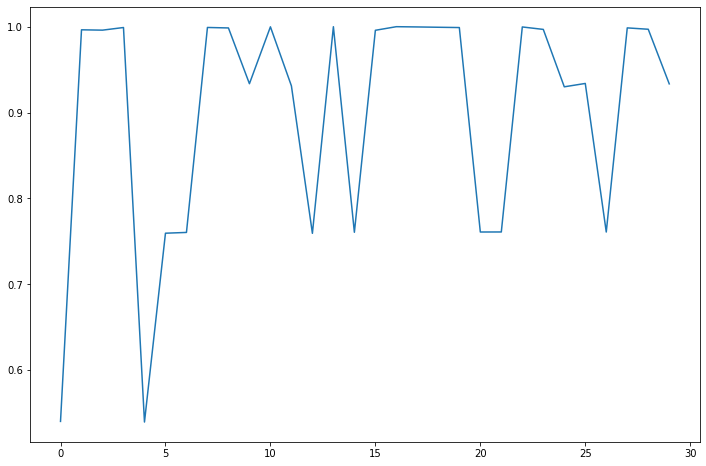

In [167]:
exibir_sumario_resultados(solucao, custos)

- Nosso algoritmo de recozimento simulado resultou em uma abordagem consideravelmente mais estável, pois apesar de ter atingido resultados muito semelhantes ao subida da encosta ele consegue atingir o ponto global em boa parte das iterações, sendo este fato refletido em uma média maisalta e no baixo desvio padrão.
- Podemos notar também que a forma alternativa de calcular a probabilidade foi efetiva.

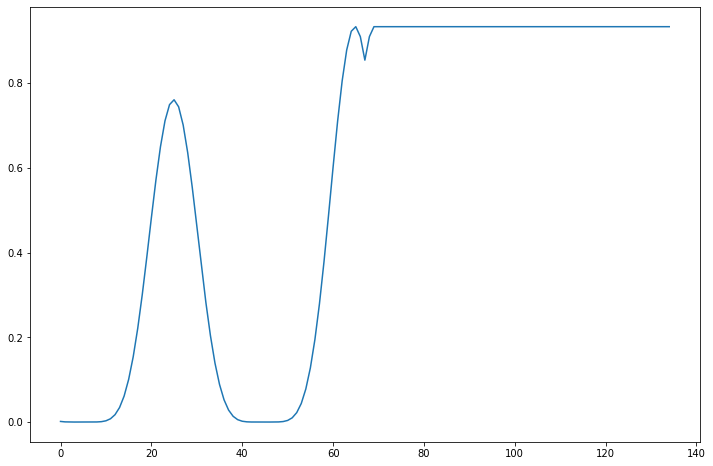

In [168]:
plotar_busca(custo_individual)

- Todas as vezes que a função acima for executa teremos um gráfico um pouco diferente, mas a ideia do algoritmo de recozimento sumilado é gerar algumas "montanhas", devido a variação de valores negativos e positivos. É possível que ele termine em um "platô", pois ele chega a um ponto na temperatura onde a probabilidade de aceitar valores negativos é muito baixa.

# Algoritmo genético
Por fim, chegamos ao algoritmo genético para tentar resolver esse problema.
- Minha implementação de algoritmo genético foi um pouco diferente da abordagem vista em aula.
- Primeiramente eu optei, nesse problema em específico, por usar a representação puramente numérica ao invés de converter os valores para binário.
- Com isso, os operadores genéticos foram feitos de forma a respeitar esse padrão
- Nos exemplos vistos em aula, temos uma array (cromossomo) composto pelos genes (cada posição no array), sendo representado dessa forma: [1,0,1,1,0].
- No meu caso, a ideia foi representar cada **INDIVÍDUO** da população como uma possível solução, onde cada dimensão é um gene e o conjunto de dimensões e meu cromossomo.
- Sendo assim nesse problema eu tenho que meu X é meu gene e também meu cromossomo (pois é um problema de apenas 1 dimensão), ficando representado dessa forma: ```indivíduo = [X]```.
- No problema que veremos a seguir de duas dimensões (X e Y), a representação fica da seguinte forma: ```indivíduo = [X, Y]```

### Mutação
- Processo aleatório que ocorre na população, mudando as características de um gene.
- Minha mutação acontece através da aplicação de uma perturbação em um determinado gene.
- Essa perturbação é uma constante e a operação realizada tem 50% de chance de ser uma somatória e 50% de ser uma subtração
- Nenhum operação é realizada caso o gene em questão extrapole os limites do domínio

In [169]:
def mutacao(solucao, dominio):
    constante = 0.05
    index_mutacao = random.randint(0, len(solucao) -1)
    gene_mutado = solucao[index_mutacao]
    solucao = list(solucao)

    if random.random() < 0.5:
        if ((gene_mutado - constante) >= dominio[0][0]):
            gene_mutado = gene_mutado - constante
    else:
        if ((gene_mutado + constante) <= dominio[0][1]):
            gene_mutado = gene_mutado + constante

    del solucao[index_mutacao]
    solucao.insert(index_mutacao, gene_mutado) 
            
    return tuple(solucao)

### crossover 
- Técnica onde os indivíduos da população compartilham os genes, distribuindo as características entre eles.
- Em problemas binários faz sentido compartilhar as características dos nossos indivíduos pais através da troca aleatorizada de genes do meu cromossomo.
- Todavia nesse caso, meu crossover não poderia ocorrer dessa forma, por se tratar de uma valor numérico. Portanto, para gerar um "filho" numérico que compartilhasse as características do pai, optei por tirar a média dos valores de cada gene.
- A média então é considerada o filho resultante.

In [170]:
def crossover(solucao1, solucao2):
    crossed = [(solucao1[i] + solucao2[i]) / 2 for i in range(len(solucao1))]
    return tuple(crossed)

### Torneio
- O torneio é a forma escolhida para seleção dos indivíduos da população.
- A diversidade da população deve variar baseado na quantidade de "competidores" por vez no torneio, a princípio escolhi 3 competidores aleatórios por vez para formar a nova população, isso da uma boa chance de escolher um valor que talvez não seja dos melhores, mas garante uma boa diversidade também.
- A quantidade de indivíduos que serão selecionados no torneio é dada pela metade do tamanho da população subtraída pelo número de elitismo, que são os indivíduos que serão conservados para próxima geração.
- Portanto se temos que nossa população é de 50 indivíduos e nosso elitismo é de 10% (5 indivíduos), nosso torneio deve selecionar (50 / 2) - 5  = 20 indivíduos.
- Com isso, teremos 25 indivíduos que serão usados para reprodução sexuada (crossover) para formar nossa população da próxima geração

In [171]:
def get_populacao_torneio(populacao, numero_individuos, objetivo, n_competidores = 3):
        nova_populacao = []
        while len(nova_populacao) < numero_individuos:
            torneio = []

            for i in range(n_competidores):
                torneio.append(populacao[random.randint(0, len(populacao) - 1)])
            
            torneio.sort(reverse=objetivo)
            nova_populacao.append(torneio[0][1])
        
        return nova_populacao

### Elitismo
- O elitismo é uma abstração que não ocorre na natureza mas podemos tirar proveitos no ambiente artificial do nosso algoritmo.
- Aqui, nós escolhemos os melhores indivíduos da nossa população e passamos esses indivíduos para próxima geração, fazendo com que eles sejam conservados em seu estado natural.
- Eu optei por escolher os melhores indivíduos me baseando apenas pelo resultado da função de custo/aptidão
- Nossa função de *get_melhores_individuos* também recebe uma parâmetro de objetivo, para informar se os que serão passado para frente pelo elitismo são os que tem maior ou menor valor, dependendo se queremos maximizar ou minimizar os valores.

In [172]:
def get_melhores_individuos(custos, n_elitismo, objetivo):
    custos.sort(reverse=objetivo)
    individuos_ordenados = [individuos for (custo, individuos) in custos]
    elite = individuos_ordenados[0:n_elitismo]
    return elite

### Geração da população
- O método *gerar_população*, como o próprio nome sugere, tem a missão de criar a nossa população inicial de indivíduos.
- Essa população possui um número N de indivíduos escolhidos pelo usuário, porém seus valores são aleatórios dentro do domínio.
- Para tentar criar uma função mais genérica, também é passado uma parâmetro que informa se o valor dos indivíduos deve ser inteiro (em caso de problemas binários) ou não.

In [194]:
def get_populacao(tamanho_populacao, dominio, numeros_inteiros = False):
    populacao = []
    random.seed(42) #comentar/descomentar para gerar uma seed para os valores "aleatórios"
    for i in range(tamanho_populacao):
        if numeros_inteiros == False:
            solucao = [random.uniform(dominio[i][0], dominio[i][1]) for i in range(
                len(dominio))]
        else:
            solucao = [random.randint(dominio[i][0], dominio[i][1]) for i in range(
                len(dominio))]
        
        populacao.append(tuple(solucao)) 
        
    return populacao

- Meu algoritmo genético foi feito de forma genérica, para que possa trabalhar tanto com os valores inteiros como também com binário.

In [220]:
def genetico(funcao_custo, dominio, objetivo = False, tamanho_populacao = 12, p_mutacao = 0.1, 
               elitismo = 0.1, geracoes=8, binario = True):
    
    populacao = get_populacao(tamanho_populacao, dominio, binario)
    
    numero_elitismo = int(elitismo * tamanho_populacao)
    
    for i in range(geracoes):
        custos = [(funcao_custo(individuo), individuo) for individuo in populacao]
        
        populacao = get_melhores_individuos(custos, numero_elitismo, objetivo) 
    
        individuos_escolhidos = get_populacao_torneio(custos, (
                                tamanho_populacao // 2) - numero_elitismo, objetivo)
    
        while len(populacao) < tamanho_populacao:
            if random.random() < p_mutacao:
                individuo_selecionado = random.randint(0, len(individuos_escolhidos) -1)
                f_mutacao = mutacao_binaria if binario == True else mutacao
                populacao.append(f_mutacao(individuos_escolhidos[individuo_selecionado], 
                                          dominio))
            else:
                individuo1 = random.randint(0, len(individuos_escolhidos) -1)
                individuo2 = random.randint(0, len(individuos_escolhidos) -1)
                f_crossover = crossover_binario if binario == True else crossover 
                populacao.append(f_crossover(individuos_escolhidos[individuo1], 
                                           individuos_escolhidos[individuo2]))
    return custos[0][0], custos[0][1]  

Solução que gerou melhor resultado: (0.0994559886036811,)
Melhor custo: 0.9997804479089255
Média de custos: 0.8366923741513563
Desvio padrão: 0.14995864231387124


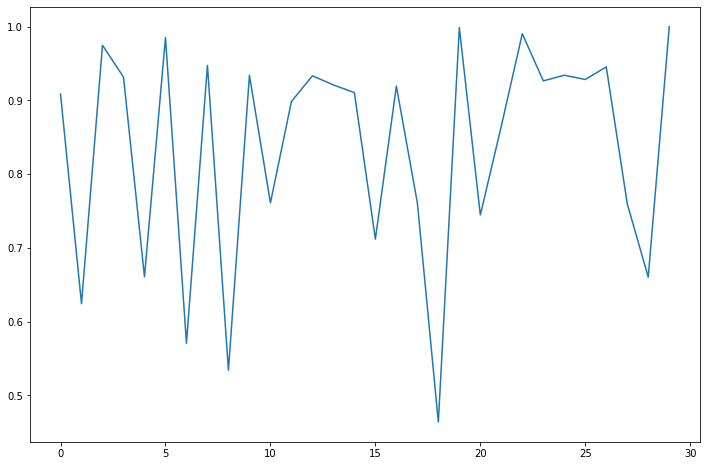

In [175]:
custos = []
solucao = []
dominio = [(0, 1)]

#Objetivo true para maximizar e false para minimizar
for i in range(30):
    solucao_algoritmo_genetico = genetico(funcao_custo, dominio, True, binario=False)
    solucao.append(solucao_algoritmo_genetico[1])
    custos.append(solucao_algoritmo_genetico[0])

exibir_sumario_resultados(solucao, custos, max)


- Podemos observar que os algoritmos genéticos, como esperado, apresentam um ótimo resultado, conseguindo atingir o máximo global na maiorio dos casos, com uma média próximo a 1 em todas as execuções e um baixo desvio padrão.
- Claro que o desempenho do algoritmo genético também vai variar bastante dependendo dos parâmetros utilizados. Algoritmos com um número maior de parâmetros geralmente são melhores para generalizar problemas complexos, apesar de ser necessário encontrar o melhor conjunto de parâmetros
- Existem algumas técnicas, geralmente por força bruta ou aleatorização, que nos permitem encontrar melhores parâmetros para se adaptar ao problema, inclusive os próprios algoritmos genéticos são usados muita das vezes para fazer a busca por melhores parâmetros em outros algoritmos como em redes neurais.
- Nesse caso não foi necessário muito esforço para buscar parâmetros defido à simplicidade do problema. Quanto maior a população inicial, maiores as chances de encontrarmos nosso máximo global, devido ao pequeno espaço de busca definido pelo domínio [0,1]

# Problema
- No terceiro problema nós devemos lidar com um problema de duas dimensões, otimizando uma formula matemática com a variável X e Y:

![title](image/formula2.png)

### Objetivo
- Minimizar o valor da formula matemática.

### Representação
- Os valores são definidos em um intervalo de [-5, 5]

In [176]:
def funcao_custo_2(valor):
    x = valor[0]
    y = valor[1]

    custo = (1-x)**2 + (100 * (y - x**2)**2)
    return custo

Solução que gerou melhor resultado: (0.8875860184041784, 0.7909380301353464)
Melhor custo: 0.013616023724069363
Média de custos: 39.44376853848381
Desvio padrão: 89.34959573577156


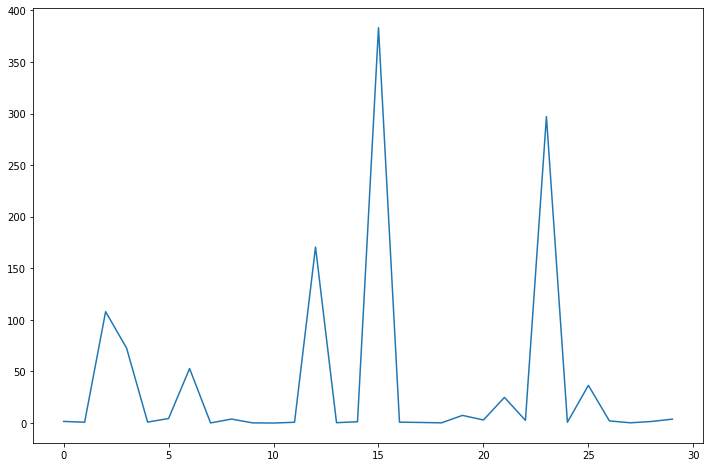

In [177]:
custos = []
solucao = []
dominio = [(-5, 5), (-5, 5)] #domínio de duas dimensões entre -5 e 5

for i in range(30):
    solucao_algoritmo_genetico = genetico(funcao_custo_2, dominio, False, binario = False)
    solucao.append(solucao_algoritmo_genetico[1])
    custos.append(solucao_algoritmo_genetico[0])

exibir_sumario_resultados(solucao, custos, min)

- O algoritmo genético conseguiu atingir bons resultados na maioria das vezes, chegando a valores de aptidão muito próximos a 0.

## Primeiro problema
- Implementação dos algoritmos genéticos para ser capaz de reconhecer o número 0, usando apenas um vetor de números binários, onde o 1 é quando o pixel é branco e o zero ele é preto 
- Nesse problema, podemos definir um critério de parada a partir do objetivo, pois estamos satisfeitos assim que conseguirmos reconhecer o número 0, diferente dos demais problemas onde apenas tentamos executar até encontrar a melhor solução possível, que é desconhecida.

### Objetivo
- Ser capaz de reconhecer o valor 0
- **Minimizar** a diferença de binários do vetor atual em relação ao vetor correto (que repesenta o número 0)

### Representação
- vetor de binários, com 12 posições: 
- [0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0]

### Nova função de custo
- Dessa vez, minha função de custo compara o vetor de exemplo (que é o número exato que eu quero detectar) com o vetor de entrada.
- A comparação me retorna um valor que diz respeito a quantos pixels existem de diferença entre o número que eu quero ser capaz de reconhecer e o número que foi passado. 
- Quanto menor esse valor mais próximos estamos do nosso número de interesse.

In [178]:
def funcao_custo_3(vetor):
    numero_zero = [1, 1, 1, 1,0, 1, 1,0, 1, 1, 1, 1]
    custo = 0
    for i in range(len(vetor)):
        if vetor[i] != numero_zero[i]:
            custo += 1
    return custo

### Nova função de crossover
- Também fiz uma nova função para o crossover, permitindo o cruzamento em caso de um array de valores binários.
- Sorteamos um valor aleatório para dividir os cromossomos pais e recombinar em um novo cromossomo que será o filho.

In [179]:
def crossover_binario(solucao1, solucao2):
    index_cruzamento = random.randint(0, len(solucao1) -1)
    solucao_resultante = solucao1[0:index_cruzamento] + solucao2[index_cruzamento:len(solucao2)]
    return solucao_resultante

### Nova função de mutação
- A função de mutação também fica diferente nesse caso, pois a mudança aplicada no gene do cromossomo não é mais uma subtração ou somatória por uma constante e sim uma mudança no valor binário.
- Essa mudança então é aplicada de forma aleatória em um dos genes do meu cromossomo, podendo mudar um binário que estava em 0 para 1 e vice versa.

In [180]:
def mutacao_binaria(solucao, dominio):
    solucao = list(solucao)
    index_mutacao = random.randint(0, len(solucao) -1)
    gene_mutado = solucao[index_mutacao]
    gene_mutado = 1 if gene_mutado == 0 else 0
    del solucao[index_mutacao]
    solucao.insert(index_mutacao, gene_mutado)
    return tuple(solucao)

In [181]:
custos = []
solucao = []
dominio = [(0, 1)] * 12

for i in range(30):
    solucao_algoritmo_genetico = genetico(funcao_custo_3, dominio_3, False)
    solucao.append(solucao_algoritmo_genetico[1])
    custos.append(solucao_algoritmo_genetico[0])

### Melhor imagem obtida
- Abaixo podemos ver a melhor imagem que conseguimos chegar na execução do algoritmo
- Basta transformar nosso vetor em uma matrix 4x3 e plotar a imagem.

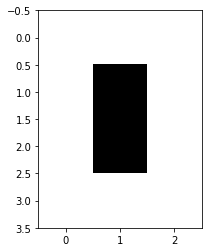

In [182]:
image = np.asmatrix(solucao[custos.index(min(custos))])
image = image.reshape(4, 3)
plt.imshow(image, cmap='gray')

Solução que gerou melhor resultado: (1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1)
Melhor custo: 0
Média de custos: 1.5666666666666667
Desvio padrão: 1.054619467970425


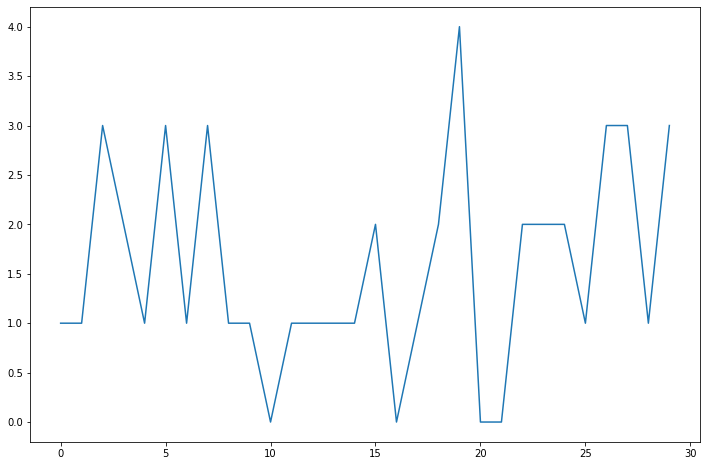

In [183]:
exibir_sumario_resultados(solucao, custos, min)

### Resultados e testes
- O algoritmo genético teve uma performance geral interessatne para detectar o padrão em questão.
- Os testes foram feitos usando diferentes parâmetros para observar o comportamento do algoritmo com um valor de 30 execuções para cada combinação de parâmetros.
- Ainda assim, cada vez que as 30 execuções acontecerem, teremos resultados levemente diferentes, devido à aleatoriedade dos algoritmos de busca

### Influência da população e das gerações nos resultados
- A ideia inicial foi gerar **variações na população**, com um valor fixo de 5 gerações. Os testes foram feitos com 8, 12, 16 e 20 indivíduos.
- Utilizar uma maior população irá nos fazer explorar uma área maior no espaço de busca, aumentando a chance de atingir bons resultados, porém com um tempo de convergência do algoritmo.
- Depois, variou - se a quantidade de gerações (5, 10, 15 e 20) mantendo a mesma população inicial de 8 indivíduos.
- As gerações são importantes para que os individuos consigam passar pela "evolução natural", sendo essencial para que o modelo convirja, porém com uma população muito pequena para o problema, corremos o risco de convergir para um ponto local ao invés do global.

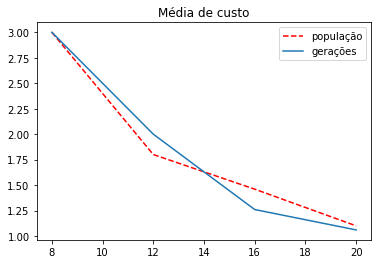

In [184]:
plt.plot([8, 12, 16, 20], [3, 1.8, 1.46, 1.1], 'r--', [8, 12, 16, 20], [3, 2, 1.26, 1.06])
plt.legend(['população', 'gerações'])
plt.title('Média de custo')
plt.show()

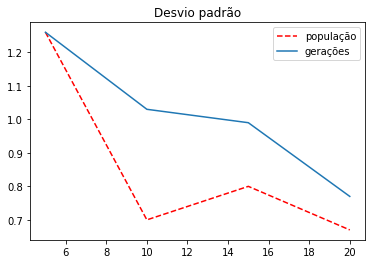

In [185]:
plt.plot([5, 10, 15, 20], [1.26, 0.7, 0.8, 0.67], 'r--', [5, 10, 15, 20], [1.26, 1.03, 0.99, 0.77])
plt.legend(['população', 'gerações'])
plt.title('Desvio padrão')
plt.show()

- Podemos observar uma diferença pequena na média de custos. Um ponto interessante, entretanto, é que aumentar a população sem aumentar as gerações nos gerou uma piora nos resultados, pois o algoritmo cria mais pontos no espaço mas não tem tempo de adaptá - los corretamente através da evolução.
- Todavia, é notável que o desvio padrão das tentativas com maior população é menor, pois como foi dito anteriormente, com mais indivíduos também temos uma chance maior de encontrar um bom ponto no nosso espaço de busca
- Portanto, como era de se esperar, o ideal é aumentar esses dois parâmetros de forma linear, pois uma maior exploração, nos exige também um maior tempo de convergência através da adaptação dos pontos nas gerações.

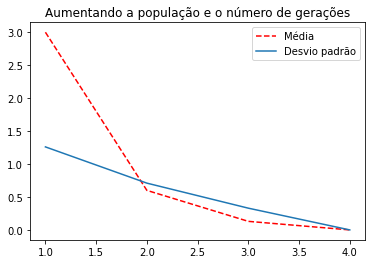

In [186]:
plt.plot([1, 2, 3, 4], [3, 0.6, 0.13, 0], 'r--', [1, 2, 3, 4], [1.26, 0.71, 0.33, 0])
plt.legend(['Média', 'Desvio padrão'])
plt.title('Aumentando a população e o número de gerações')
plt.show()

- Dessa vez a população e as gerações cresceram juntas: 8 e 5, 12 e 10, 16 e 15 e 20 e 20 respectivamente.
- Conseguimos atingir um ponto máximo de convergência na última execução, com uma média e desvio de 0, pois o número 0 foi detectado em todas as 30 execuções.

### Influência na mutação e no crossover nos resultados
- Para testar as diferentes mutações e taxas de crossover, utilizei uma população de 8 indivíduos em 5 gerações, por se tratar da minha configuração inicial.
- Minha configuração inicial foi de uma probabilidade de 20% de mutação e 80% de crossover, obtendo uma média de 3 e desvio padrão de 1.26 como vimos anteriormente.
- Ao executar o algoritmo com 100% de probabilidade de mutação obtemos: **média = 2.53 e desvio padrão = 1.3**
- O inverso também foi testado, com 100% de probabilidade de crossover, obtendo: **média = 3.5 e desvio padrão = 1.14**
- Como podemos observar, aumentar a taxa de crossover ao máximo nos trouxe piores médias, possivelmente causadas por conta dos pontos no espaço se prenderem ao máximo local, já que sem mutação a exploração é menor, todavia, pelo mesmo motivo é que temos resultados mais estáveis, com um desvio padrão menor
- Já na mutação, atingimos uma média maior, pois nossos pontos conseguem percorrer mais livremente o espaço de busca todavia o desvio padrão foi maior, mostrando a instabilidade que uma abordagem muito exploratória pode trazer para nosso algoritmo

### Determinando os melhores valores de mutação e crossover
- Como o crossover e a mutação são duas variáveis que vão de 0 a 1, podemos usar a força bruta para tentar determinar qual a melhor combinação desses parâmetro para resover nosso problema.
- A ideia é testar diferentes combinações de probabilidade de mutação e crossover, começando com 100% de chance de crossover e 0% de mutação e incrementando e decrementando respectivamente em 0.05, até que esses valores se invertam, ou seja, se tornem em 100% de chance de acontecer mutação e 0% de crossover.
- Uma outra alteração que fiz para melhorar a vizualização gráfica dos resultados foi converter o valor do custo em uma porcentagem de precisão. Lembrando que nosso custo originalmente é a distância de 0 a 12 entre nosso número 0 e o que o algoritmo tentou gerar de solução.
- Com isso, ao invés de retornar entre 0 e 12 o retorno se deu entre 0 e 1, onde 1
representa 100% de acerto.
- Também fixei uma seed (semente) na geração dos valores "aleatórios", para que o teste não tenha influência do acaso

In [221]:
custos = []
dominio = [(0, 1)] * 12
p_mutacao = [-0.05]
crossover = [1.05]

for i in range(int(1 / 0.05) + 1):
    p_mutacao.append(p_mutacao[len(p_mutacao)- 1] + 0.05)
    crossover.append(crossover[len(crossover)- 1] - 0.05)
    solucao_algoritmo_genetico = genetico(funcao_custo_3, dominio, False, p_mutacao = 
                                           p_mutacao[len(p_mutacao) - 1])

    custos.append((12 - solucao_algoritmo_genetico[0]) / 12 ) #convertendo em %

p_mutacao.pop(0)

-0.05

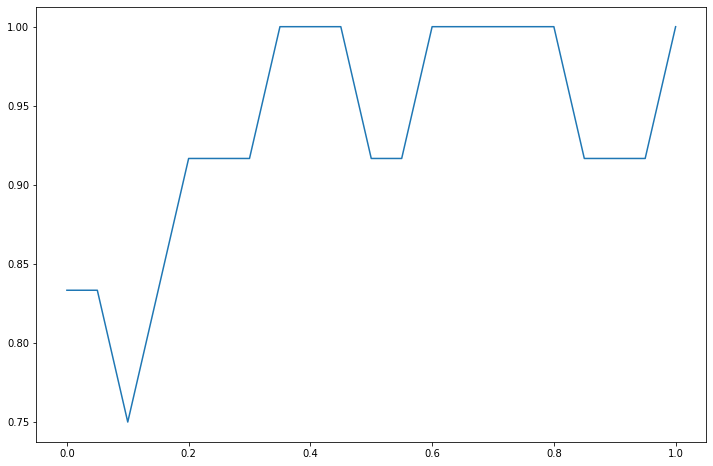

In [222]:
plt.figure(figsize=(12,8))
plt.plot(p_mutacao, custos)
plt.show()

In [223]:
melhores_taxas = [p_mutacao[i] for i, x in enumerate(custos) if x == 1.0]
for i in melhores_taxas:
    print('Probabilidade de mutação', i, 'probabilidade de crossover', 1 - i)

Probabilidade de mutação 0.35 probabilidade de crossover 0.65
Probabilidade de mutação 0.39999999999999997 probabilidade de crossover 0.6000000000000001
Probabilidade de mutação 0.44999999999999996 probabilidade de crossover 0.55
Probabilidade de mutação 0.6 probabilidade de crossover 0.4
Probabilidade de mutação 0.65 probabilidade de crossover 0.35
Probabilidade de mutação 0.7000000000000001 probabilidade de crossover 0.29999999999999993
Probabilidade de mutação 0.7500000000000001 probabilidade de crossover 0.2499999999999999
Probabilidade de mutação 0.8000000000000002 probabilidade de crossover 0.19999999999999984
Probabilidade de mutação 1.0000000000000002 probabilidade de crossover -2.220446049250313e-16


- Podemos ver acima os valores de mutação e crossover que geraram os melhores resultados (100% de acerto)
- Claro que esses valores são dependentes dos parâmetros que discutimos anteriormente de população e número de gerações
- O ideal seria trabalhar otimizando todos os parâmetros de forma conjunta, existem alguns métodos combinatórios para isso, porém devido à simplicidade do problema, como já foi observado, não é uma abordagem necessária necs